## Neural networks for segmentation

In [1]:
! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
! unzip -q data.zip

--2019-05-07 09:56:38--  https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jy34yowcf85ydba/data.zip [following]
--2019-05-07 09:56:39--  https://www.dropbox.com/s/raw/jy34yowcf85ydba/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0906af44ee9f4ffdc053f63c50.dl.dropboxusercontent.com/cd/0/inline/AgbbX5UCuU8ZLnziRQ1FEMOlSYBeHachsZL20SQIMIwrF3a4AGhr_KcMn5erbjVFbjPc0bOU_Pm7KEEyptfhzbqrIWnt3ItGwmhoV0kGzc_b6g/file# [following]
--2019-05-07 09:56:39--  https://uc0906af44ee9f4ffdc053f63c50.dl.dropboxusercontent.com/cd/0/inline/AgbbX5UCuU8ZLnziRQ1FEMOlSYBeHachsZL20SQIMIwrF3a4AGhr_KcMn5erbjVFbjPc0bOU_Pm7KEEyptfhzbqrIWnt3ItGwmhoV0kGzc_b6g/file
Resolving uc0906af44ee9f4f

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [0]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


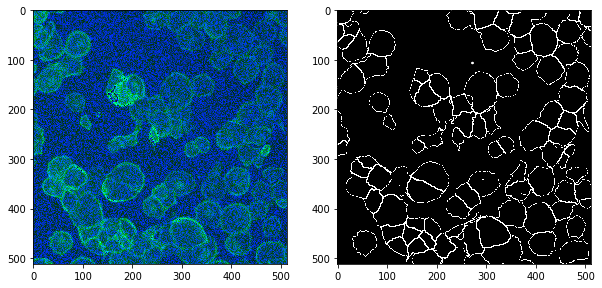

In [3]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [0]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [5]:
!ls -al BBBC018_v1_outlines/val

total 232
drwxr-xr-x 2 root root  4096 Mar 20  2017 .
drwx------ 4 root root  4096 Mar 22  2017 ..
-rwx------ 1 root root 42643 Jun  6  2012 00734-cells.png
-rwx------ 1 root root 16502 Jun  6  2012 07313-cells.png
-rwx------ 1 root root 17968 Jun  6  2012 09337-cells.png
-rwx------ 1 root root 36421 Jun  6  2012 13363-cells.png
-rwx------ 1 root root 32993 Jun  6  2012 15964-cells.png
-rwx------ 1 root root 33317 Jun  6  2012 17302-cells.png
-rwx------ 1 root root 32016 Jun  6  2012 19467-cells.png


In [0]:
train_folder_source = 'BBBC018_v1_images-fixed/train/'
val_folder_source = 'BBBC018_v1_images-fixed/val/'
train_folder_target = 'BBBC018_v1_outlines/train/'
val_folder_target = 'BBBC018_v1_outlines/val/'

In [0]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import torch.optim as optim
import os

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Since this task can be not so bad solved with usual cv methods, I think that the model mustn't be very deep. And let's use classic cv method for our baseline. 

In [9]:
!pip install opencv-python

It seems like images are quite noisy, let's first remove this noise. During network training we'll see if there is a difference with denoisning or without it.

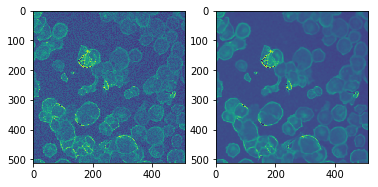

In [10]:
import cv2 as cv
im = cv.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
dst = cv.fastNlMeansDenoisingColored(im,None,10,60,21,7)
dst = cv.cvtColor(dst, cv.COLOR_BGR2GRAY)
im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

plt.subplot(121),plt.imshow(im)
plt.subplot(122),plt.imshow(dst)
plt.show()

In [11]:
np.unique(np.array(cv.imread('BBBC018_v1_outlines/train/00735-cells.png'))) # https://i.gifer.com/CRek.gif

array([  0,   1,   2,   8,   9,  35,  54,  80, 201, 202, 239, 240, 255],
      dtype=uint8)

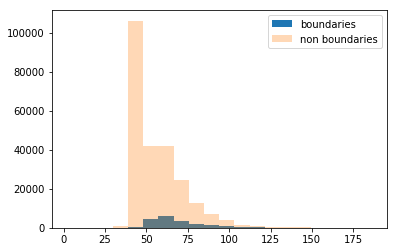

In [12]:
mask = cv.imread('BBBC018_v1_outlines/train/00735-cells.png')
graymask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
m = np.array(graymask)

im = cv.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
dst = cv.fastNlMeansDenoisingColored(im,None,10,60,21,7)
imgray = cv.cvtColor(dst, cv.COLOR_BGR2GRAY)

plt.hist(imgray[m>0],bins=20)
plt.hist(imgray[m==0],bins=20, alpha=0.3)
plt.legend(['boundaries', 'non boundaries'])
#plt.subplot(2,1,2)

The biggest pillar in the histogram for non boundaries is of course the background. It seems like simple thresholding will not work. It's better to find gradients. Let's see what we'll get if we calculate the laplacian of the image

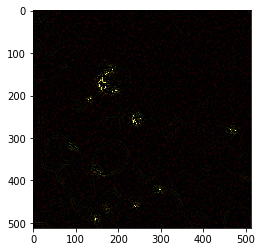

In [13]:
im = cv.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
dst = cv.fastNlMeansDenoisingColored(im,None,10,60,21,7)
laplacian = cv.Laplacian(dst,cv.CV_8U)
plt.imshow(laplacian)

It's easy to see these bold black lines. We work in the right direction

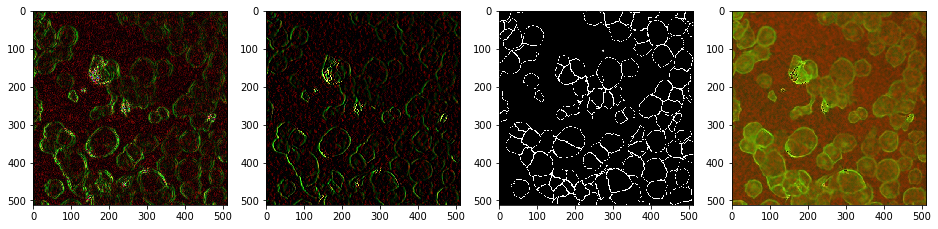

In [14]:
im = cv.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
dst = cv.fastNlMeansDenoisingColored(im,None,10,30,21,7)
sobelx8u = cv.Sobel(dst,cv.CV_8U,1,0,ksize=3)
sobelx64f = cv.Sobel(dst,cv.CV_64F,1,0,ksize=3)
abs_sobel64f = np.absolute(sobelx64f)
sobel_8u = np.uint8(abs_sobel64f)
plt.figure(figsize=(16,9))
plt.subplot(1,4,1)
plt.imshow(sobel_8u)
plt.subplot(1,4,2)
plt.imshow(sobelx8u)
plt.subplot(1,4,3)
plt.imshow(mask)
plt.subplot(1,4,4)
plt.imshow(dst)

So, actually I couldn't find desired threshold, but I think this research above we'll be helpful for the network training.
Let's first try autoencoder network. But we'll not restore the image, so we don't need MSE loss. It turns out this is the classification task, so it's better to use for example cross entropy loss for each  pixel.

In [0]:
from os import listdir
from os.path import isfile, join
from torch.utils.data import Dataset
from PIL import Image
import random

class Cells(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, source_dir, target_dir=None, transform=None, denoise=False, random_crop_size=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.source_dir = source_dir
        self.target_dir = target_dir
        self.source_files = sorted([f for f in listdir(source_dir) if isfile(join(source_dir, f))]) # SORTED VERY IMPORTANT, LOST 2 HOURS DEALING WITH "WTF IT DOESN'T WORK"
        print(self.source_files)
        
        if target_dir:
          self.target_files = sorted([f for f in listdir(target_dir) if isfile(join(target_dir, f))])
        else:
          self.target_files = None
        
        print(self.target_files)
    
        self.transform = transform
        self.denoise = denoise
        self.random_crop_size = random_crop_size

    def __len__(self):
        return len(self.source_files)
      
    def randcropparams(self, img, output_size):
      w, h = img.size
      th, tw = output_size
      if w == tw and h == th:
          return 0, 0, h, w

      i = random.randint(0, h - th)
      j = random.randint(0, w - tw)
      return i, j, th, tw          

    def __getitem__(self, idx):
        i,j,h,w = 0,0,0,0
        image = cv.imread(join(self.source_dir, self.source_files[idx]))
        
        if self.denoise:
          image = cv.fastNlMeansDenoisingColored(image,None,10,60,21,7)
        
        image = Image.fromarray(image)
        
        if self.random_crop_size is not None:
          i,j,h,w = self.randcropparams(image, self.random_crop_size)
          image = transforms.functional.crop(image, i, j, h, w)
        
        if self.transform:
            image = self.transform(image)
            
        image = np.array(image)
        
          
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)  
        sample = {'image': torch.tensor(np.array(image)[None,:,:], dtype=torch.float32)}
        
        if self.target_files:
          target = cv.imread(join(self.target_dir, self.target_files[idx]))
          target = Image.fromarray(target)
          if self.random_crop_size is not None:
            target = transforms.functional.crop(target, i, j, h, w)
            
          if self.transform:
            target = self.transform(target)
          target = np.array(target)
          target = cv.cvtColor(target, cv.COLOR_BGR2GRAY)
          target[target > 0] = 1 # let the mask be indeed binary
          sample['target'] = torch.tensor(np.array(target)[None,], dtype=torch.float32)

        return sample

In [0]:
# change to banch of simple convolutions
class simplenet(nn.Module):
    def __init__(self):
        super(simplenet, self).__init__()
        """
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=2),  # b, 16, 10, 10  || b, 16, 172, 172 
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5 || b, 16, 86, 86
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3 || b, 8, 
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Sigmoid()
        )
        """
        self.encoder = nn.Sequential(
          nn.ReLU(True),
          nn.Conv2d(1, 128, 5, padding=2),
          nn.BatchNorm2d(128),
          nn.PReLU(),
          nn.Conv2d(128, 64, 3, padding=1),
          nn.BatchNorm2d(64),
          nn.PReLU(),
          nn.Conv2d(64, 64, 3, padding=1),
          nn.BatchNorm2d(64),
          nn.PReLU(),
        )
        self.decoder = nn.Sequential(
          nn.Conv2d(64, 1, 1, stride=1, padding=0),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [159]:
"""
        transforms.RandomChoice(
        [
            transforms.RandomHorizontalFlip(),
            transforms.Compose([]),
            transforms.Compose([
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
            ]),
            transforms.Compose([
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomHorizontalFlip()
            ]),
            transforms.Compose([
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
            ]),
            transforms.Compose([
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
            ]),
            transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
                transforms.RandomRotation(degrees=(-5,5)),
            ]),
        ]
    ),
"""
data_transform = transforms.Compose([])

train_dataset = Cells(train_folder_source, train_folder_target, transform=data_transform, random_crop_size=(512,512), denoise=True)
train_loader = data.DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = Cells(val_folder_source, val_folder_target, transform=data_transform, denoise=True)
val_loader = data.DataLoader(val_dataset, batch_size=1)

['00735-actin.DIB.bmp', '00736-actin.DIB.bmp', '03997-actin.DIB.bmp', '03998-actin.DIB.bmp', '03999-actin.DIB.bmp', '04000-actin.DIB.bmp', '05621-actin.DIB.bmp', '05622-actin.DIB.bmp', '05623-actin.DIB.bmp', '05897-actin.DIB.bmp', '05898-actin.DIB.bmp', '05900-actin.DIB.bmp', '07314-actin.DIB.bmp', '07315-actin.DIB.bmp', '07316-actin.DIB.bmp', '09338-actin.DIB.bmp', '09339-actin.DIB.bmp', '09340-actin.DIB.bmp', '10777-actin.DIB.bmp', '10778-actin.DIB.bmp', '13362-actin.DIB.bmp', '13364-actin.DIB.bmp', '13570-actin.DIB.bmp', '13571-actin.DIB.bmp', '13572-actin.DIB.bmp', '15961-actin.DIB.bmp', '15962-actin.DIB.bmp', '15963-actin.DIB.bmp', '16817-actin.DIB.bmp', '16818-actin.DIB.bmp', '16819-actin.DIB.bmp', '16820-actin.DIB.bmp', '17301-actin.DIB.bmp', '17303-actin.DIB.bmp', '17304-actin.DIB.bmp', '17673-actin.DIB.bmp', '17674-actin.DIB.bmp', '17675-actin.DIB.bmp', '17676-actin.DIB.bmp', '19465-actin.DIB.bmp', '19468-actin.DIB.bmp']
['00735-cells.png', '00736-cells.png', '03997-cells.png'

In [0]:
model = simplenet().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(7, dtype=torch.float32, device=device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [112]:
!pip install livelossplot

In [0]:
def confusion(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

In [0]:
from livelossplot import PlotLosses

dataloaders = {
    "train": train_loader,
    "validation": val_loader
}

In [0]:
sig = nn.Sigmoid()
def train_model(model, criterion, optimizer, num_epochs=10, path_to_save_models='models/tezd1/'):
    try:
        os.makedirs(path_to_save_models)
    except Exception:
        pass
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            tp,fp,tn,fn = 0,0,0,0
            iou = []

            for sample in dataloaders[phase]:
                inputs = sample['image'].to(device)
                labels = sample['target'].to(device)

                outputs = model(inputs)
                
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                preds = sig(outputs)
                
                # DEBUG
                """
                if phase == 'validation':
                  plt.figure(figsize=(16,9))
                  plt.subplot(1,3,1)
                  plt.imshow(labels[0].cpu().detach().numpy()[0])
                  plt.subplot(1,3,2)
                  plt.imshow(outputs[0].cpu().detach().numpy()[0])
                """
                
                preds[preds >= 0.5] = 1.0 # threshold 0.5 may be not the best choice
                preds[preds < 0.5] = 0.0
                
                """
                if phase == 'validation':
                  plt.subplot(1,3,3)
                  plt.imshow(preds[0].cpu().detach().numpy()[0])
                  
                """
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
               
                
                tp_temp, fp_temp, tn_temp, fn_temp = confusion(preds, labels.data)
                tp += tp_temp
                fp += fp_temp
                tn += tn_temp
                fn += fn_temp
                iou.append(calc_iou(preds.cpu().detach().numpy(), labels.data.cpu().detach().numpy()))

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(tp)
            try:
              epoch_precision = tp / (tp+fp)
            except Exception as e:
              epoch_precision = 0.0
            try:
              epoch_recall = tp / (tp+fn)
            except Exception as e:
              epoch_recall = 0.0
            iou_score = torch.mean(torch.Tensor([iou]))
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'cross entropy loss'] = epoch_loss.item()
            logs[prefix + 'precision'] = epoch_precision
            logs[prefix + 'recall'] = epoch_recall
            logs[prefix + 'mean iou'] = iou_score.item()
        
        liveloss.update(logs)
        liveloss.draw()
        
        
        
        if epoch % 50 == 9:
            torch.save(model.state_dict(), os.path.join(path_to_save_models, 'epoch_{}.mdl'.format(epoch)))
            
        if epoch == 49:
          optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5) # lower step for stability
          optimizer.zero_grad()
          

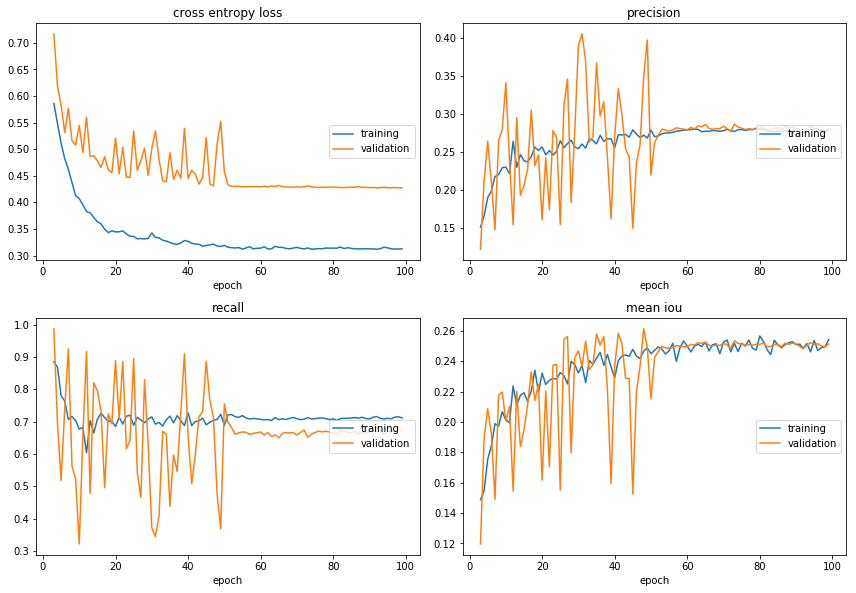

cross entropy loss:
training   (min:    0.312, max:    0.729, cur:    0.312)
validation (min:    0.427, max:    0.912, cur:    0.428)

precision:
training   (min:    0.115, max:    0.281, cur:    0.279)
validation (min:    0.054, max:    0.406, cur:    0.280)

recall:
training   (min:    0.604, max:    0.950, cur:    0.711)
validation (min:    0.321, max:    0.993, cur:    0.672)

mean iou:
training   (min:    0.110, max:    0.257, cur:    0.254)
validation (min:    0.054, max:    0.261, cur:    0.251)


KeyboardInterrupt: ignored

In [151]:
train_model(model, criterion, optimizer, num_epochs=200)

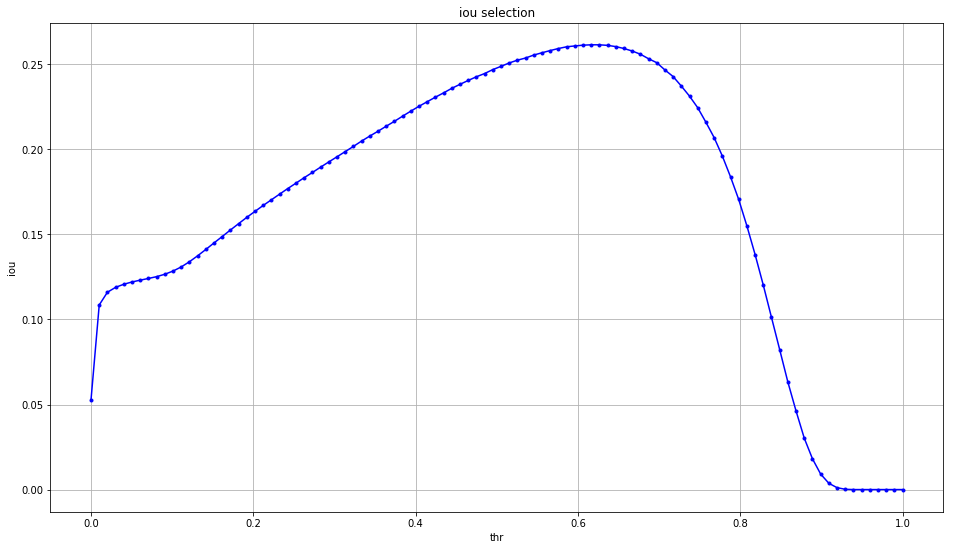

Best thr: 0.6161616161616162, best iou: 0.26150753978172125


In [152]:
thrs = np.linspace(0, 1, num=100)

model.eval()
ious = np.zeros(100)

for i in range(len(thrs)):

  predictions = []
  gts = []

  for sample in dataloaders['validation']:
      inputs = sample['image'].to(device)
      labels = sample['target'].to(device)

      outputs = model(inputs)

      preds = sig(outputs)

      preds[preds >= thrs[i]] = 1.0
      preds[preds < thrs[i]] = 0.0

      predictions.append(preds.cpu().detach().numpy())
      gts.append(labels.data.cpu().detach().numpy())

  ious[i] = calc_iou(predictions, gts)

plt.figure(figsize=(16,9))
plt.plot(thrs, ious, ".-b")
plt.title('iou selection')
plt.xlabel('thr')
plt.ylabel('iou')
plt.grid()
plt.show()

i_best = np.argmax(ious)
print("Best thr: {}, best iou: {}".format(thrs[i_best], ious[i_best]))

So, I think I spent to much time for this. Let's stop just stop... I still beleive that this task can be solved unsupervised with cv and via simple (not so deep like unet for example) neural network.

**try with denoise**


(denoise=True)
It seems like the convergence rate is a little bit faster in terms of number of iterations, however every iteration performes longer because of denoising (I could just save denoised dataset and it would be ok but I didn't, nevermind...).

In terms of the final score there is no any significant improvements

In [0]:
train_dataset = Cells(train_folder_source, train_folder_target, transform=data_transform, random_crop_size=(512,512), denoise=True)
train_loader = data.DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = Cells(val_folder_source, val_folder_target, transform=data_transform, denoise=True)
val_loader = data.DataLoader(val_dataset, batch_size=1)

In [0]:
model = simplenet().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(7, dtype=torch.float32, device=device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [0]:
dataloaders = {
    "train": train_loader,
    "validation": val_loader
}

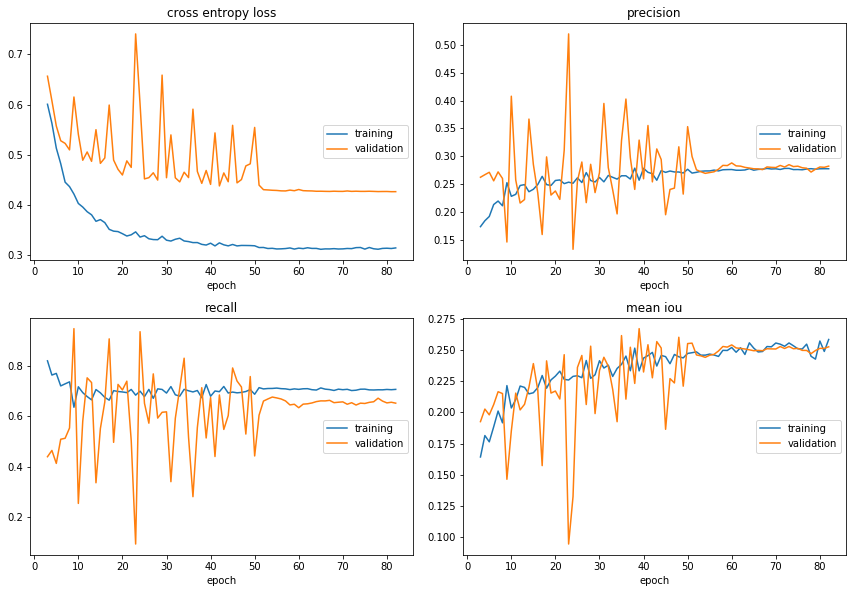

cross entropy loss:
training   (min:    0.312, max:    0.715, cur:    0.315)
validation (min:    0.427, max:    0.942, cur:    0.427)

precision:
training   (min:    0.131, max:    0.279, cur:    0.278)
validation (min:    0.053, max:    0.519, cur:    0.282)

recall:
training   (min:    0.635, max:    0.871, cur:    0.706)
validation (min:    0.093, max:    1.000, cur:    0.651)

mean iou:
training   (min:    0.126, max:    0.258, cur:    0.258)
validation (min:    0.053, max:    0.267, cur:    0.253)


KeyboardInterrupt: ignored

In [164]:
train_model(model, criterion, optimizer, num_epochs=200)

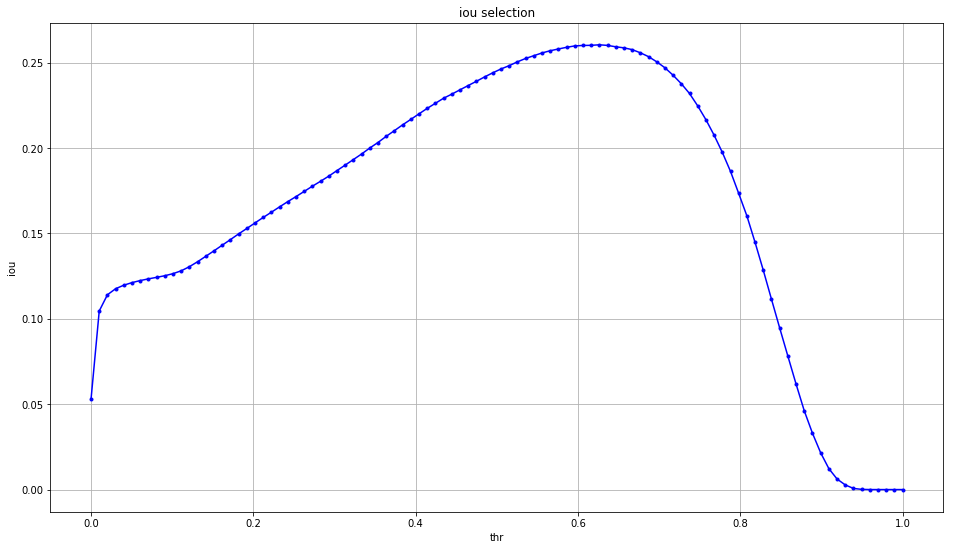

Best thr: 0.6262626262626263, best iou: 0.26045703958542005


In [165]:
thrs = np.linspace(0, 1, num=100)

model.eval()
ious = np.zeros(100)

for i in range(len(thrs)):

  predictions = []
  gts = []

  for sample in dataloaders['validation']:
      inputs = sample['image'].to(device)
      labels = sample['target'].to(device)

      outputs = model(inputs)

      preds = sig(outputs)

      preds[preds >= thrs[i]] = 1.0
      preds[preds < thrs[i]] = 0.0

      predictions.append(preds.cpu().detach().numpy())
      gts.append(labels.data.cpu().detach().numpy())

  ious[i] = calc_iou(predictions, gts)

plt.figure(figsize=(16,9))
plt.plot(thrs, ious, ".-b")
plt.title('iou selection')
plt.xlabel('thr')
plt.ylabel('iou')
plt.grid()
plt.show()

i_best = np.argmax(ious)
print("Best thr: {}, best iou: {}".format(thrs[i_best], ious[i_best]))